In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import pandasql as sql
import random

In [2]:
class world_bank():
    def __init__(self,indicator_string):
        self.indicator_string=indicator_string
        url='http://api.worldbank.org/v2/country/all/indicator/'
        url=url+self.indicator_string+f"?format=json"
        data=requests.get(url)
        new_data=data.json()

        page_n=new_data[0]['total']


        url=url+f"&per_page={page_n}"

        data=requests.get(url)
        new_data=data.json()
        
        self.new_data=new_data[1]
        
        
    def get_countries(self):
        unique_country_names = []
        for i in pd.DataFrame(self.new_data)['country']:
            if i['value'] not in unique_country_names:
                unique_country_names.append(i['value'])
            
        group_of_countries = []
        countries = []
        reached_afganistan = False
        
        for country in unique_country_names:
            if reached_afganistan == False:
            
                if country == 'Afghanistan':
                    reached_afganistan = True
                    countries.append(country)
                
                elif country != 'Afghanistan':
                    group_of_countries.append(country)

            elif reached_afganistan == True:
                countries.append(country)

        return group_of_countries, countries
        
        
    def get_indicator(self,country=None,name=None):
        
        if name==None:
            name=self.indicator_string
            
        
        dataset = []
        
        if country != None:
            for i in self.new_data:

                if i['country']['value'] in country:

                    country_name = i['country']['value']
                    date_value= int( i['date'] )

                    if i['value'] != None:
                        wb_indicator = i['value']

                    else:
                        wb_indicator = np.nan

                    dataset.append([country_name,date_value,wb_indicator])
        
        else:
            
            for i in self.new_data:
                country_name = i['country']['value']
                date_value= int( i['date'] )

                if i['value'] != None:
                    wb_indicator = i['value']

                else:
                    wb_indicator = np.nan

                dataset.append([country_name,date_value,wb_indicator])


        return pd.DataFrame(dataset,columns=['country_name','date_value',name],index=None)
    
    

1) Expense (% of GDP)
International Monetary Fund, Government Finance Statistics Yearbook and data files,
and World Bank and OECD GDP estimates:

'GC.XPN.TOTL.GD.ZS'


2) GDP per capita (current US$)
World Bank national accounts data, and OECD National Accounts data files.

'NY.GDP.PCAP.CD'


3) Merchandise exports (current US$)
World Trade Organization


'TX.VAL.MRCH.CD.WT'


4) Merchandise imports (current US$)
World Trade Organization

'TM.VAL.MRCH.CD.WT'

5) Population, total
United Nations Population Division. World Population Prospects: 2019 Revision. ( 2 ) Census reports and other statistical publications from national statistical offices

'SP.POP.TOTL'


In [3]:
expenses = 'GC.XPN.TOTL.GD.ZS'
gdp_per_capita = 'NY.GDP.PCAP.CD'
exports = 'TX.VAL.MRCH.CD.WT'
imports = 'TM.VAL.MRCH.CD.WT'
population = 'SP.POP.TOTL'

In [4]:
data = world_bank(expenses)
countries_list =data.get_countries()


In [5]:
countries_list = countries_list[1]

In [6]:
expenses = data.get_indicator(country=countries_list,name='expenses')

In [7]:
expenses['expenses'].notnull().sum()/len(expenses['expenses'])

0.2843544609805847

In [8]:
data = world_bank(gdp_per_capita)
gdp_per_capita = data.get_indicator(country=countries_list,name='gdp_per_capita')
gdp_per_capita['gdp_per_capita'].notnull().sum() / len(gdp_per_capita['gdp_per_capita'])

0.7645236836141119

In [9]:
data = world_bank(exports)
exports = data.get_indicator(country=countries_list,name='exports')
exports['exports'].notnull().sum() / len(exports['exports'])

0.8181612147767621

In [10]:
data = world_bank(imports)
imports = data.get_indicator(country=countries_list,name='imports')
imports['imports'].notnull().sum() / len(imports['imports'])

0.814383923849815

In [11]:
data = world_bank(population)
population = data.get_indicator(country=countries_list,name='population')
population['population'].notnull().sum() / len(population['population'])

0.9968270756213644

In [12]:
lines = '''
    SELECT cap.country_name, pop.population, cap.date_value, cap.gdp_per_capita,
    ex.expenses, exp.exports, imp.imports
    
    FROM population pop CROSS JOIN gdp_per_capita cap
            ON ( cap.country_name = pop.country_name AND 
                cap.date_value = pop.date_value)
                
         CROSS JOIN expenses ex 
            ON ( cap.country_name = ex.country_name AND 
                cap.date_value = ex.date_value)
            
        CROSS JOIN exports exp
            ON ( exp.country_name = ex.country_name AND 
                exp.date_value = ex.date_value)
                
        CROSS JOIN imports imp
            ON (imp.country_name = exp.country_name AND
                imp.date_value = exp.date_value)

'''

world_bank_data=sql.sqldf(lines)

In [13]:
world_bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13237 entries, 0 to 13236
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country_name    13237 non-null  object 
 1   population      13195 non-null  float64
 2   date_value      13237 non-null  int64  
 3   gdp_per_capita  10120 non-null  float64
 4   expenses        3764 non-null   float64
 5   exports         10830 non-null  float64
 6   imports         10780 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 724.0+ KB


In [14]:
world_bank_data['import_per_person'] = world_bank_data['imports']/world_bank_data['population']

world_bank_data['export_per_person'] = world_bank_data['exports']/world_bank_data['population']

world_bank_data['trade_deficit'] = world_bank_data['imports']-world_bank_data['exports']

In [15]:
index_of_economic_freedom = pd.read_csv('data/index_of_economic_freedom_heritage_foundation.csv')

In [16]:
index_of_economic_freedom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5152 entries, 0 to 5151
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Name                       5152 non-null   object 
 1   index_year                 5152 non-null   int64  
 2   index_of_economic_freedom  4618 non-null   float64
 3   property_rights            4655 non-null   float64
 4   government_integrity       4671 non-null   float64
 5   judicial_effectiveness     1099 non-null   float64
 6   tax_burden                 4634 non-null   float64
 7   government_spending        4650 non-null   float64
 8   fiscal_health              1092 non-null   float64
 9   business_freedom           4667 non-null   float64
 10  labor_freedom              3173 non-null   float64
 11  monetary_freedom           4656 non-null   float64
 12  trade_freedom              4641 non-null   float64
 13  investment_freedom         4656 non-null   float

In [17]:
for i in range(2015,2023):
    print(f"happiness_report{i} = pd.read_csv('data/{i}.csv')")

happiness_report2015 = pd.read_csv('data/2015.csv')
happiness_report2016 = pd.read_csv('data/2016.csv')
happiness_report2017 = pd.read_csv('data/2017.csv')
happiness_report2018 = pd.read_csv('data/2018.csv')
happiness_report2019 = pd.read_csv('data/2019.csv')
happiness_report2020 = pd.read_csv('data/2020.csv')
happiness_report2021 = pd.read_csv('data/2021.csv')
happiness_report2022 = pd.read_csv('data/2022.csv')


In [18]:
happiness_report2015 = pd.read_csv('data/2015.csv')
happiness_report2016 = pd.read_csv('data/2016.csv')
happiness_report2017 = pd.read_csv('data/2017.csv')
happiness_report2018 = pd.read_csv('data/2018.csv')
happiness_report2019 = pd.read_csv('data/2019.csv')
happiness_report2020 = pd.read_csv('data/2020.csv')
happiness_report2021 = pd.read_csv('data/2021.csv')
happiness_report2022 = pd.read_csv('data/2022.csv')

In [19]:
for i in range(2015,2023):
    print(f"happiness_report{i}['year'] = {i}")


happiness_report2015['year'] = 2015
happiness_report2016['year'] = 2016
happiness_report2017['year'] = 2017
happiness_report2018['year'] = 2018
happiness_report2019['year'] = 2019
happiness_report2020['year'] = 2020
happiness_report2021['year'] = 2021
happiness_report2022['year'] = 2022


In [20]:
happiness_report2015['year'] = 2015
happiness_report2016['year'] = 2016
happiness_report2017['year'] = 2017
happiness_report2018['year'] = 2018
happiness_report2019['year'] = 2019
happiness_report2020['year'] = 2020
happiness_report2021['year'] = 2021
happiness_report2022['year'] = 2022

In [21]:
happiness_report2015.columns == happiness_report2016.columns
happiness_report2016.columns == happiness_report2017.columns
happiness_report2017.columns == happiness_report2018.columns
happiness_report2018.columns == happiness_report2019.columns
happiness_report2019.columns == happiness_report2020.columns
happiness_report2020.columns == happiness_report2021.columns
happiness_report2021.columns == happiness_report2022.columns

array([ True,  True,  True,  True,  True,  True,  True])

In [22]:
happiness_report2017.head()

,country,happiness_score,life_expectancy,freedom_of_choices,government_corruption,generosity,year
0,Norway,7.537,0.796667,0.635423,0.315964,0.362012,2017
1,Denmark,7.522,0.792566,0.626007,0.400770,0.355280,2017
2,Iceland,7.504,0.833552,0.627163,0.153527,0.475540,2017
3,Switzerland,7.494,0.858131,0.620071,0.367007,0.290549,2017
4,Finland,7.469,0.809158,0.617951,0.382612,0.245483,2017


In [23]:
lines='''
    SELECT * FROM happiness_report2015
    UNION
    SELECT * FROM happiness_report2016
    UNION
    SELECT * FROM happiness_report2017
    UNION
    SELECT * FROM happiness_report2018
    UNION
    SELECT * FROM happiness_report2019
    UNION
    SELECT * FROM happiness_report2020
    UNION
    SELECT * FROM happiness_report2021
    UNION
    SELECT * FROM happiness_report2022
    
'''

world_happiness_report = sql.sqldf(lines)

In [24]:
world_happiness_report.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 1230 non-null   object 
 1    happiness_score        1230 non-null   float64
 2    life_expectancy        1230 non-null   float64
 3    freedom_of_choices     1230 non-null   float64
 4    government_corruption  1229 non-null   float64
 5    generosity             1230 non-null   float64
 6   year                    1230 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 67.4+ KB


In [25]:
world_happiness_report.head()

,country,happiness_score,life_expectancy,freedom_of_choices,government_corruption,generosity,year
0,Afghanistan,2.5230,52.49300,0.382000,0.924000,-0.102000,2021
1,Afghanistan,2.5669,52.59000,0.396573,0.933687,-0.096429,2020
2,Afghanistan,3.2030,0.36100,0.000000,0.025000,0.158000,2019
3,Afghanistan,3.3600,0.17344,0.164300,0.071120,0.312680,2016
4,Afghanistan,3.5750,0.30335,0.234140,0.097190,0.365100,2015


In [26]:
lines = '''
    SELECT *
    
    FROM world_happiness_report wh LEFT JOIN index_of_economic_freedom ef
    ON (ef.Name = wh.country AND ef.index_year = wh.year)

'''

e_freedom_w_happiness = sql.sqldf(lines)

In [27]:
e_freedom_w_happiness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   country                    1230 non-null   object 
 1    happiness_score           1230 non-null   float64
 2    life_expectancy           1230 non-null   float64
 3    freedom_of_choices        1230 non-null   float64
 4    government_corruption     1229 non-null   float64
 5    generosity                1230 non-null   float64
 6   year                       1230 non-null   int64  
 7   Name                       1118 non-null   object 
 8   index_year                 1118 non-null   float64
 9   index_of_economic_freedom  1082 non-null   float64
 10  property_rights            1109 non-null   float64
 11  government_integrity       1116 non-null   float64
 12  judicial_effectiveness     823 non-null    float64
 13  tax_burden                 1091 non-null   float

In [28]:
e_freedom_w_happiness.drop(['Name','index_year'], axis=1,inplace=True)

In [29]:
e_freedom_w_happiness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   country                    1230 non-null   object 
 1    happiness_score           1230 non-null   float64
 2    life_expectancy           1230 non-null   float64
 3    freedom_of_choices        1230 non-null   float64
 4    government_corruption     1229 non-null   float64
 5    generosity                1230 non-null   float64
 6   year                       1230 non-null   int64  
 7   index_of_economic_freedom  1082 non-null   float64
 8   property_rights            1109 non-null   float64
 9   government_integrity       1116 non-null   float64
 10  judicial_effectiveness     823 non-null    float64
 11  tax_burden                 1091 non-null   float64
 12  government_spending        1106 non-null   float64
 13  fiscal_health              820 non-null    float

In [30]:
e_freedom_w_happiness.columns

Index(['country', ' happiness_score', ' life_expectancy',
       ' freedom_of_choices', ' government_corruption', ' generosity', 'year',
       'index_of_economic_freedom', 'property_rights', 'government_integrity',
       'judicial_effectiveness', 'tax_burden', 'government_spending',
       'fiscal_health', 'business_freedom', 'labor_freedom',
       'monetary_freedom', 'trade_freedom', 'investment_freedom',
       'financial_freedom'],
      dtype='object')

In [31]:
dict_column = {}
replace_column = ['country', 'happiness_score', 'life_expectancy',
       'freedom_of_choices', 'government_corruption', 'generosity', 'year',
       'index_of_economic_freedom', 'property_rights', 'government_integrity',
       'judicial_effectiveness', 'tax_burden', 'government_spending',
       'fiscal_health', 'business_freedom', 'labor_freedom',
       'monetary_freedom', 'trade_freedom', 'investment_freedom',
       'financial_freedom']
for i,ii in zip(e_freedom_w_happiness.columns,replace_column):
    dict_column[i]=ii

e_freedom_w_happiness.rename(columns=dict_column,inplace=True)

In [32]:
happy_freedom_string = ""
n=0
for i in [i for i in e_freedom_w_happiness.columns]:
    if n==0:
        
        happy_freedom_string = happy_freedom_string + f"ew.{i}"
        
    else:
        happy_freedom_string = happy_freedom_string + f",ew.{i}"
    n+=1
    
happy_freedom_string=happy_freedom_string.replace(' ','')
happy_freedom_string

'ew.country,ew.happiness_score,ew.life_expectancy,ew.freedom_of_choices,ew.government_corruption,ew.generosity,ew.year,ew.index_of_economic_freedom,ew.property_rights,ew.government_integrity,ew.judicial_effectiveness,ew.tax_burden,ew.government_spending,ew.fiscal_health,ew.business_freedom,ew.labor_freedom,ew.monetary_freedom,ew.trade_freedom,ew.investment_freedom,ew.financial_freedom'

In [33]:
e_freedom_w_happiness.columns

Index(['country', 'happiness_score', 'life_expectancy', 'freedom_of_choices',
       'government_corruption', 'generosity', 'year',
       'index_of_economic_freedom', 'property_rights', 'government_integrity',
       'judicial_effectiveness', 'tax_burden', 'government_spending',
       'fiscal_health', 'business_freedom', 'labor_freedom',
       'monetary_freedom', 'trade_freedom', 'investment_freedom',
       'financial_freedom'],
      dtype='object')

In [34]:
world_bank_string = ""
n=0
for i in [i for i in world_bank_data.columns]:
    if n==0:
        
        world_bank_string = world_bank_string + f"wb.{i}"
        
    else:
        world_bank_string = world_bank_string + f",wb.{i}"
    n+=1
    
world_bank_string=world_bank_string.replace(' ','')
world_bank_string

'wb.country_name,wb.population,wb.date_value,wb.gdp_per_capita,wb.expenses,wb.exports,wb.imports,wb.import_per_person,wb.export_per_person,wb.trade_deficit'

In [35]:
lines = f'''
    SELECT {happy_freedom_string},{world_bank_string}
            
    
    FROM e_freedom_w_happiness ew LEFT JOIN world_bank_data wb
    
    ON (ew.country = wb.country_name AND ew.year = wb.date_value)

'''

# final_data=sql.sqldf(lines)
final_data = sql.sqldf(lines)

In [36]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   country                    1230 non-null   object 
 1   happiness_score            1230 non-null   float64
 2   life_expectancy            1230 non-null   float64
 3   freedom_of_choices         1230 non-null   float64
 4   government_corruption      1229 non-null   float64
 5   generosity                 1230 non-null   float64
 6   year                       1230 non-null   int64  
 7   index_of_economic_freedom  1082 non-null   float64
 8   property_rights            1109 non-null   float64
 9   government_integrity       1116 non-null   float64
 10  judicial_effectiveness     823 non-null    float64
 11  tax_burden                 1091 non-null   float64
 12  government_spending        1106 non-null   float64
 13  fiscal_health              820 non-null    float

In [37]:
final_data['year'].unique()

array([2021, 2020, 2019, 2016, 2015, 2018, 2017, 2022])

In [38]:
def correlation_expert(data,column,correlation='pearson'):
    correlation_expert = data.corr(correlation)    
    return correlation_expert[column].sort_values(ascending=False)

In [39]:
correlation_expert(final_data,'happiness_score')

happiness_score              1.000000
freedom_of_choices           0.974367
life_expectancy              0.967492
generosity                   0.847287
government_corruption        0.792192
gdp_per_capita               0.726811
import_per_person            0.585875
export_per_person            0.559614
year                         0.559482
expenses                     0.368293
imports                      0.294096
exports                      0.293500
judicial_effectiveness       0.164571
property_rights              0.144704
government_integrity         0.108041
financial_freedom            0.072507
investment_freedom           0.063807
business_freedom             0.053185
index_of_economic_freedom    0.042351
trade_deficit                0.036616
date_value                   0.026136
monetary_freedom             0.020908
tax_burden                  -0.024014
labor_freedom               -0.034090
government_spending         -0.036232
population                  -0.059463
trade_freedo

In [40]:
correlation_expert(final_data,'freedom_of_choices')

freedom_of_choices           1.000000
happiness_score              0.974367
life_expectancy              0.939552
generosity                   0.848493
government_corruption        0.796588
year                         0.547972
date_value                   0.450993
gdp_per_capita               0.324953
import_per_person            0.263297
export_per_person            0.262864
exports                      0.147822
judicial_effectiveness       0.144163
imports                      0.137029
property_rights              0.132376
government_integrity         0.096376
financial_freedom            0.068418
investment_freedom           0.056931
population                   0.050797
business_freedom             0.044762
index_of_economic_freedom    0.037944
monetary_freedom             0.020707
tax_burden                  -0.003752
government_spending         -0.013246
trade_deficit               -0.017132
labor_freedom               -0.041148
trade_freedom               -0.078730
expenses    

In [41]:
correlation_expert(final_data,'life_expectancy')


life_expectancy              1.000000
happiness_score              0.967492
freedom_of_choices           0.939552
generosity                   0.791632
government_corruption        0.781938
date_value                   0.648516
year                         0.626736
judicial_effectiveness       0.189385
property_rights              0.183511
government_integrity         0.137437
financial_freedom            0.086168
investment_freedom           0.077370
business_freedom             0.073505
index_of_economic_freedom    0.064463
expenses                     0.042232
gdp_per_capita               0.034484
import_per_person            0.020357
monetary_freedom             0.019179
exports                      0.018756
imports                      0.017256
export_per_person            0.016216
population                   0.004634
trade_deficit               -0.002593
labor_freedom               -0.027978
tax_burden                  -0.029095
government_spending         -0.045091
trade_freedo

In [42]:
correlation_expert(final_data,'happiness_score',correlation='spearman')

happiness_score              1.000000
gdp_per_capita               0.841585
export_per_person            0.792314
import_per_person            0.790940
life_expectancy              0.653846
exports                      0.634258
imports                      0.618781
property_rights              0.587389
freedom_of_choices           0.583188
government_integrity         0.563094
index_of_economic_freedom    0.532138
business_freedom             0.526291
financial_freedom            0.518116
judicial_effectiveness       0.480617
investment_freedom           0.467618
trade_freedom                0.434982
government_corruption        0.421429
expenses                     0.380829
year                         0.349505
generosity                   0.341267
monetary_freedom             0.332906
labor_freedom                0.176349
fiscal_health                0.143440
date_value                   0.031067
population                  -0.112420
trade_deficit               -0.116977
tax_burden  

In [43]:
correlation_expert(final_data,'life_expectancy',correlation='spearman')

life_expectancy              1.000000
freedom_of_choices           0.807140
year                         0.760888
government_corruption        0.744025
happiness_score              0.653846
gdp_per_capita               0.616630
import_per_person            0.592622
export_per_person            0.563350
expenses                     0.508281
date_value                   0.496118
property_rights              0.490896
imports                      0.457017
exports                      0.443366
government_integrity         0.408587
index_of_economic_freedom    0.354464
business_freedom             0.344476
financial_freedom            0.329390
investment_freedom           0.314241
judicial_effectiveness       0.297065
monetary_freedom             0.214631
trade_freedom                0.200964
labor_freedom                0.099842
fiscal_health                0.045639
trade_deficit               -0.007898
generosity                  -0.023673
population                  -0.087247
tax_burden  

In [44]:
year = 2018

lines= "select * from final_data where country='Mali' and year={int_number}".format(int_number = year)
mali=sql.sqldf(lines)

lines= "select * from final_data where country='India' and year={int_number}".format(int_number = year)
india=sql.sqldf(lines)

lines= "select * from final_data where country='United States' and year={int_number}".format(int_number = year)
us=sql.sqldf(lines)

lines= "select * from final_data where country='Switzerland' and year={int_number}".format(int_number = year)
swis=sql.sqldf(lines)

In [45]:
def countries_compare(x,y):
    
    line1=ax.scatter(mali.loc[0,x],mali.loc[0,y],s=150,c='black')
    line2=ax.scatter(india.loc[0,x],india.loc[0,y],s=150,c='red')
    line3=ax.scatter(us.loc[0,x],us.loc[0,y],s=150,c='yellow')
    line4=ax.scatter(swis.loc[0,x],swis.loc[0,y],s=150,c='green')
    
    return line1,line2,line3,line4

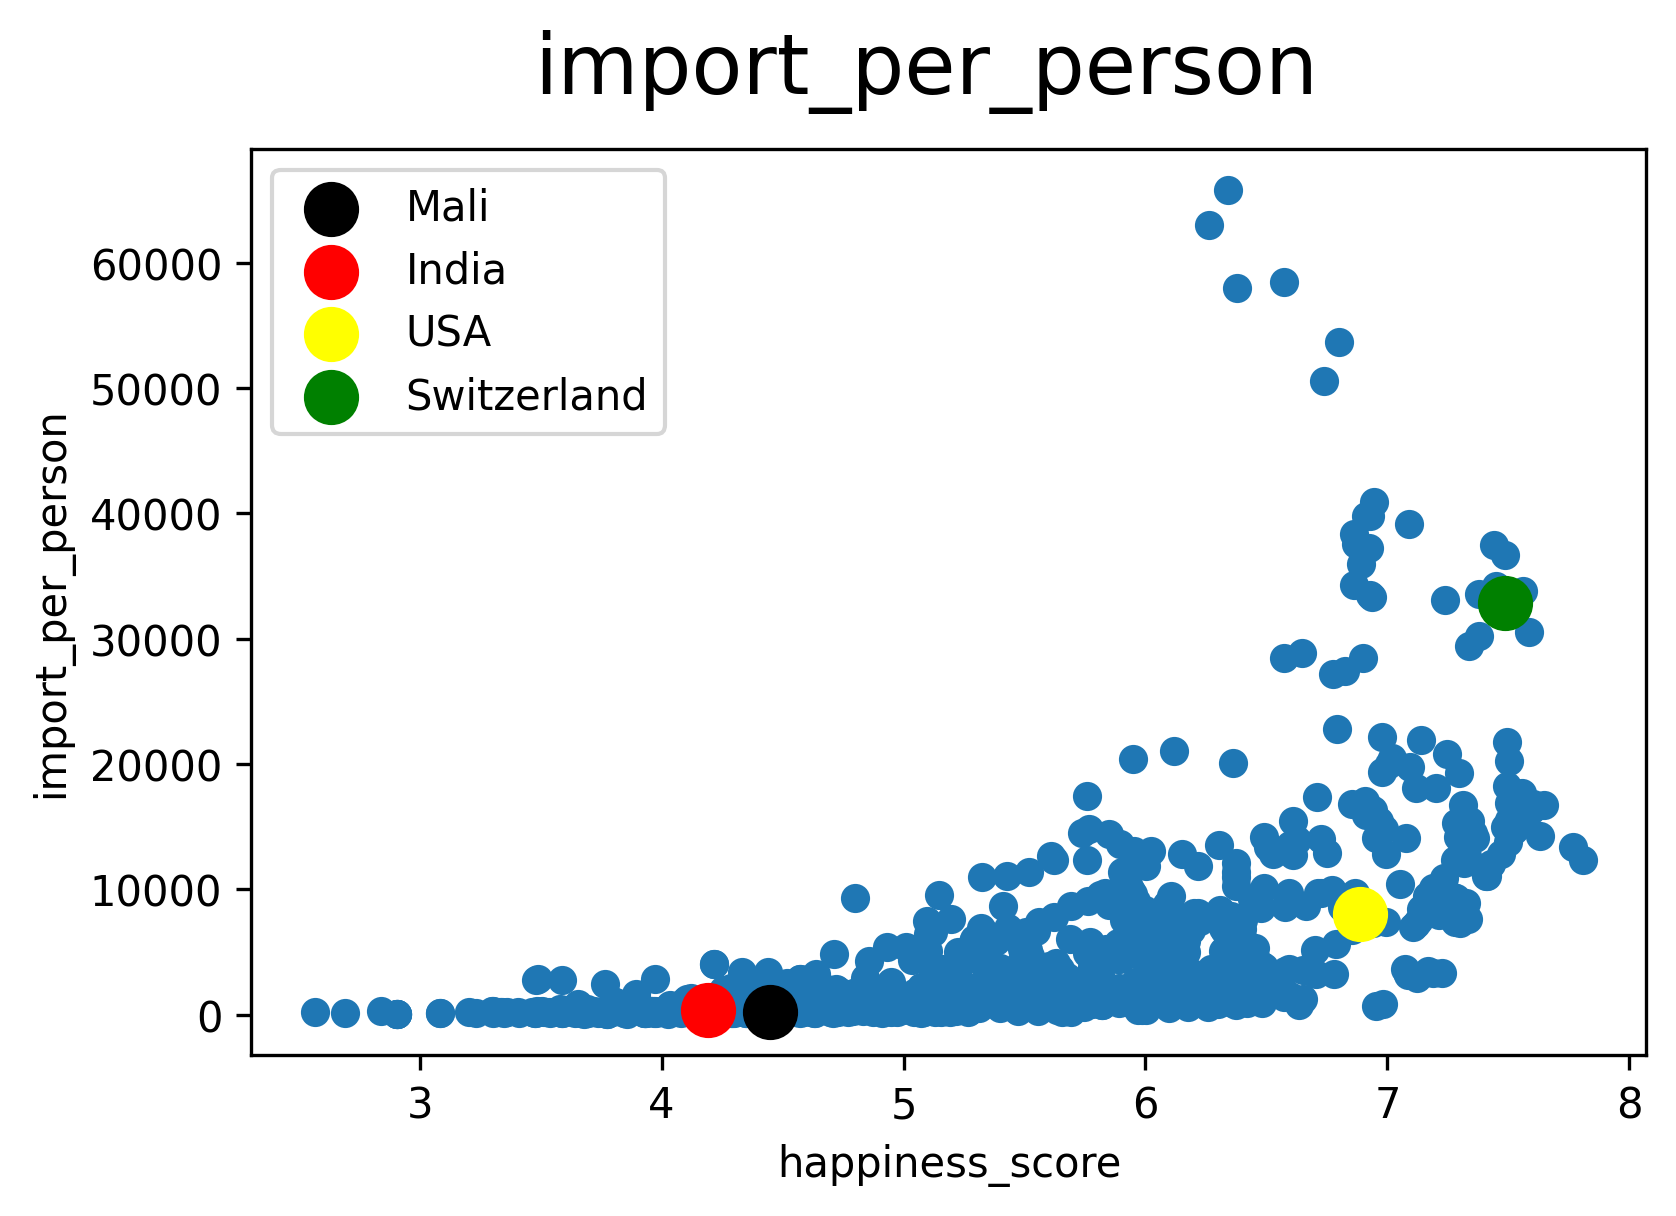

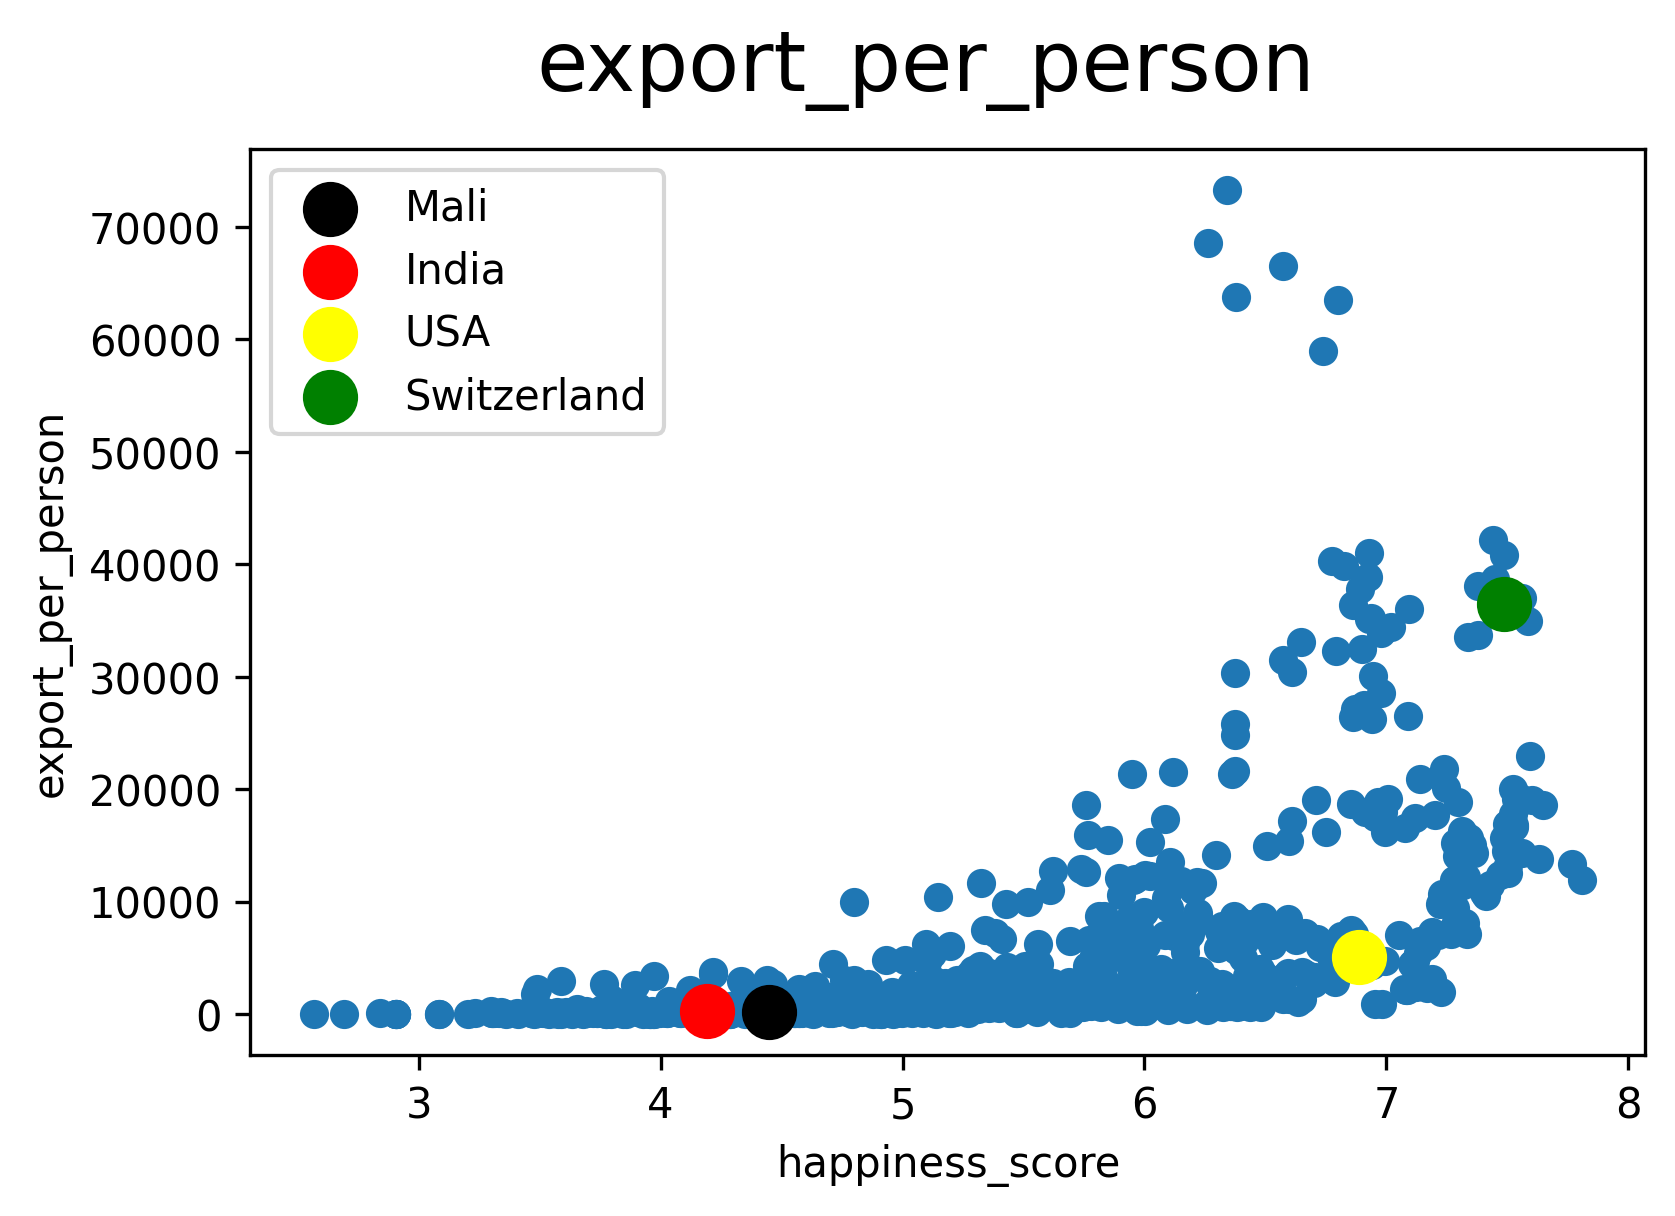

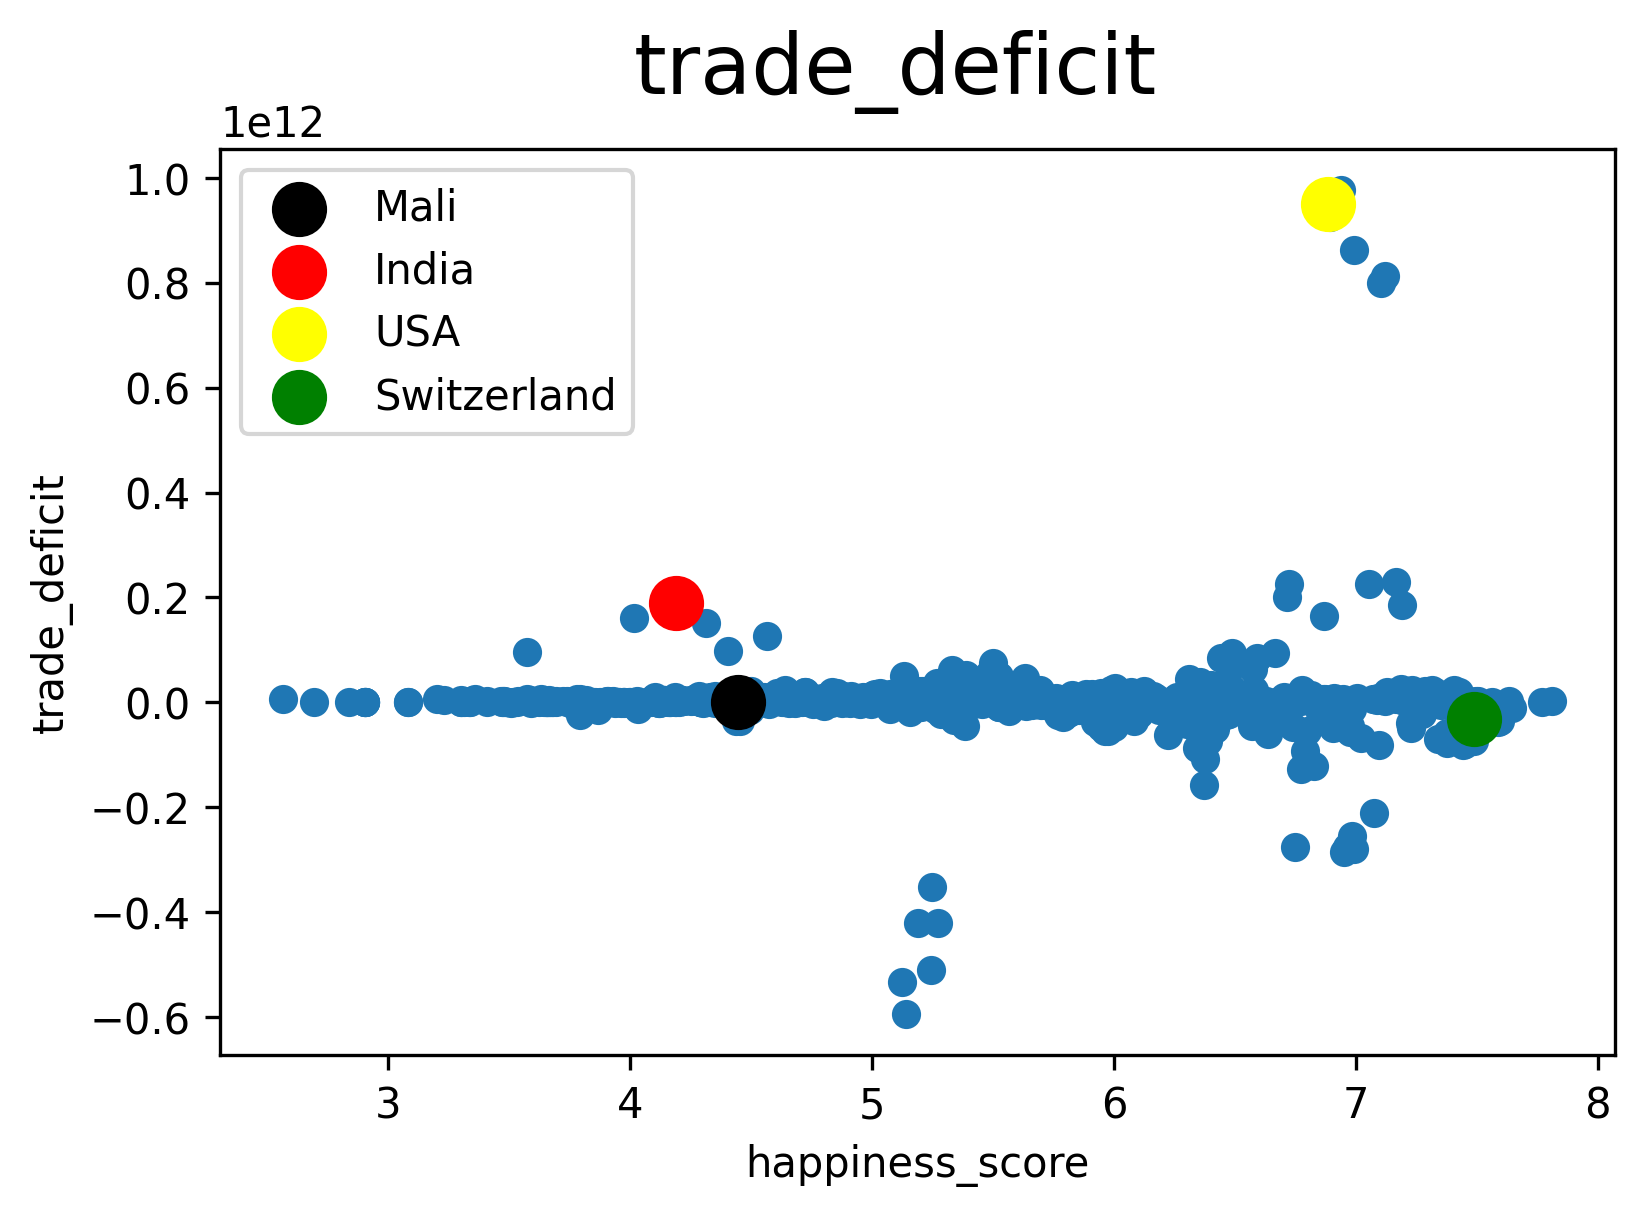

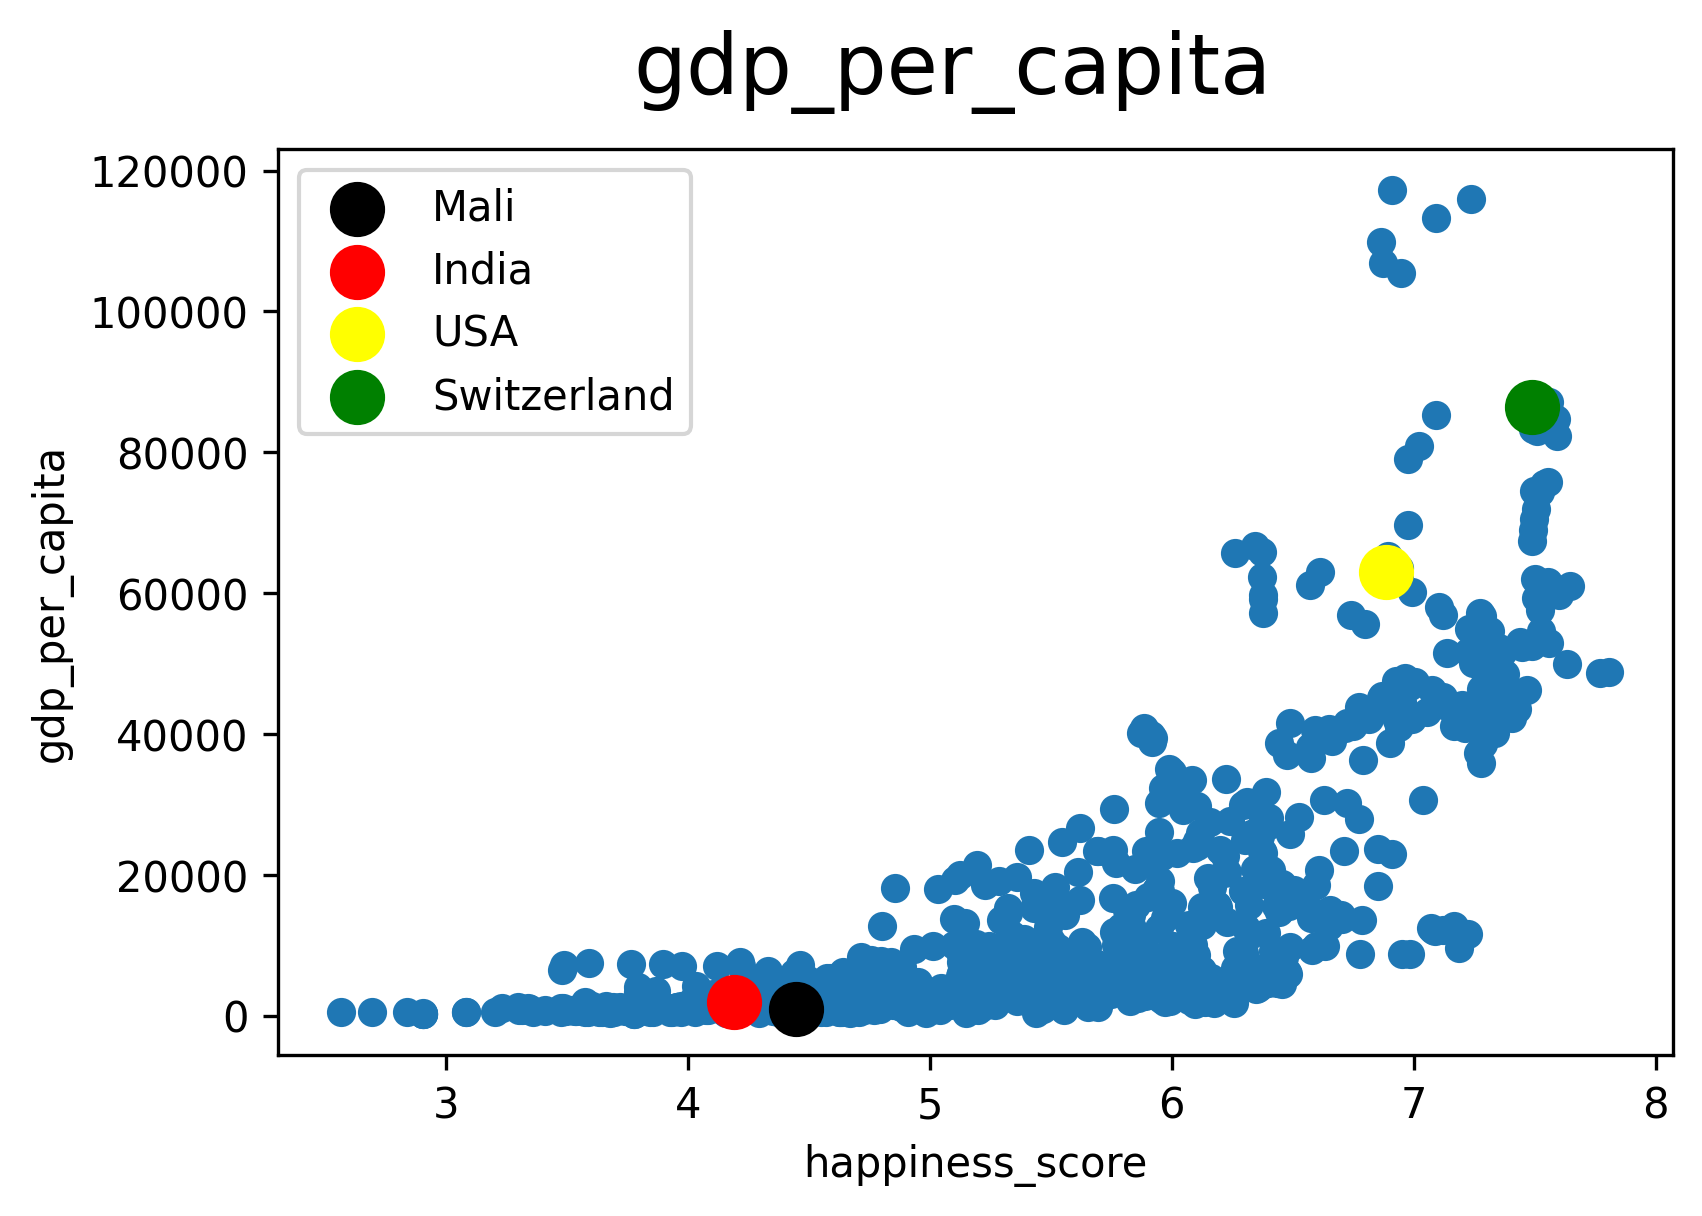

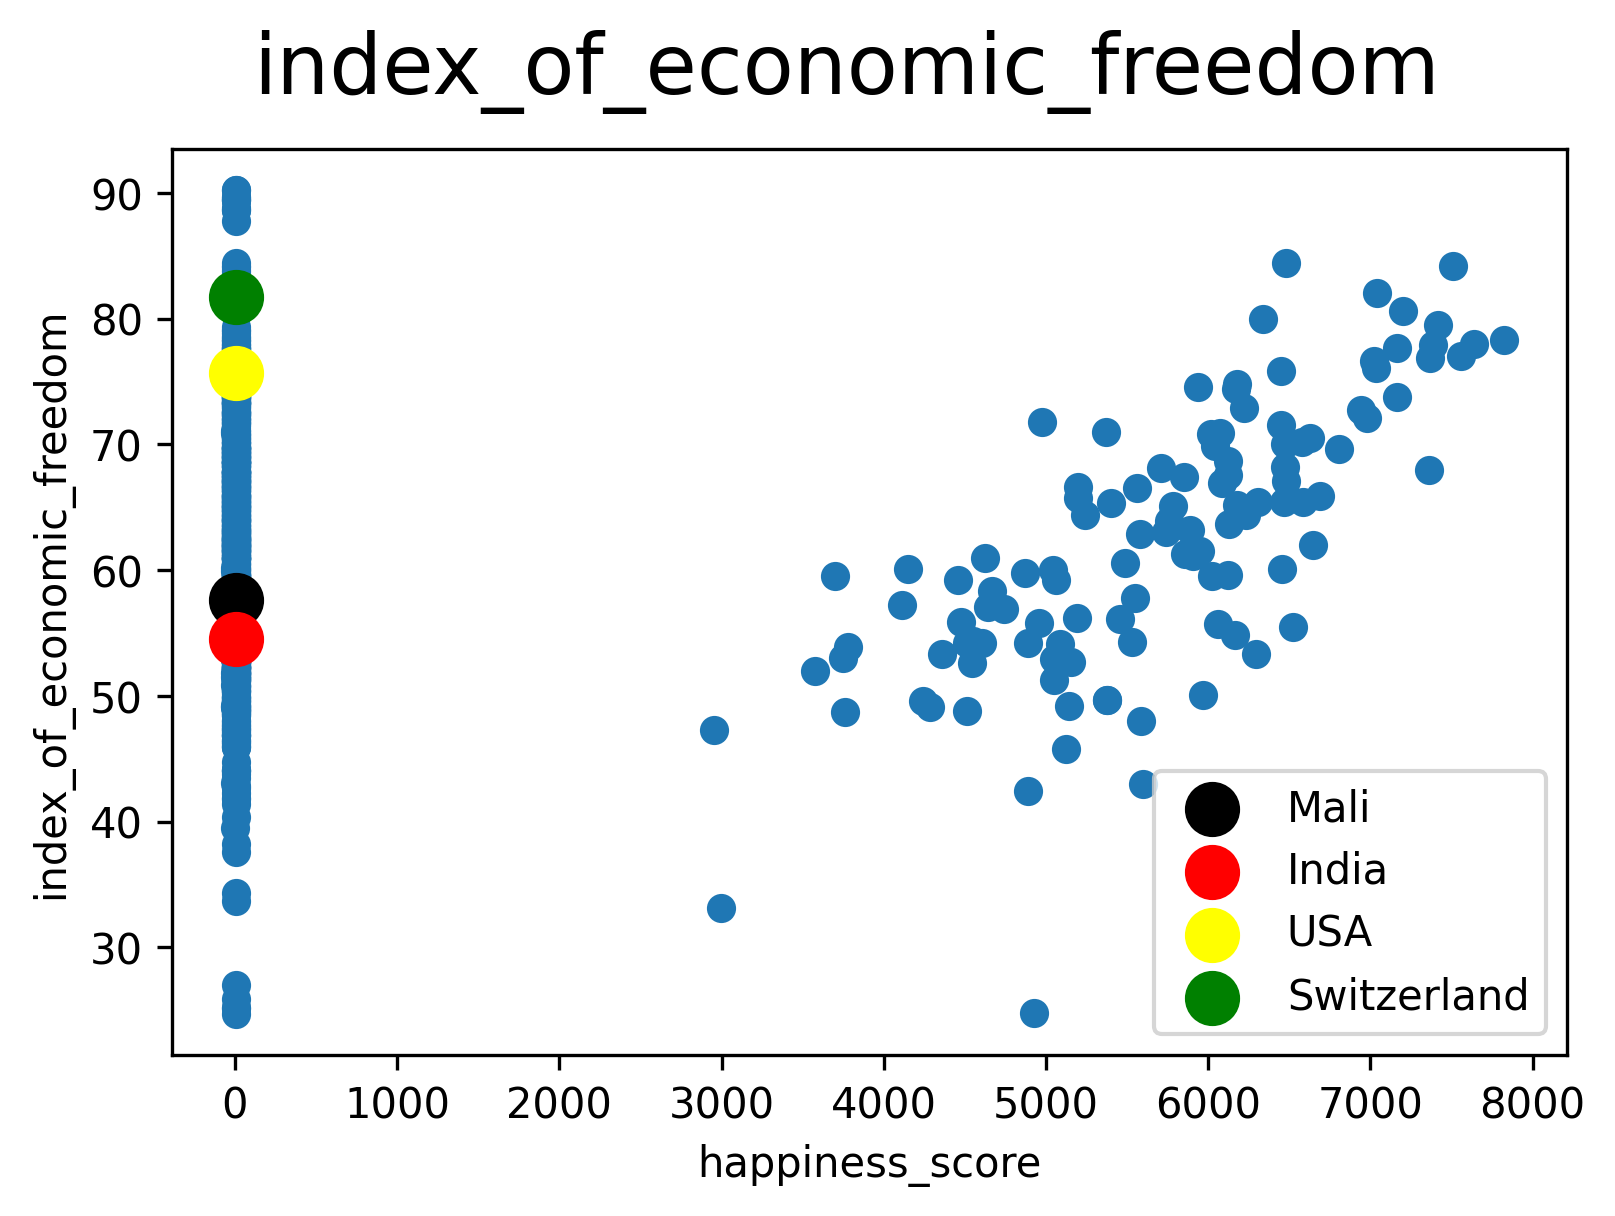

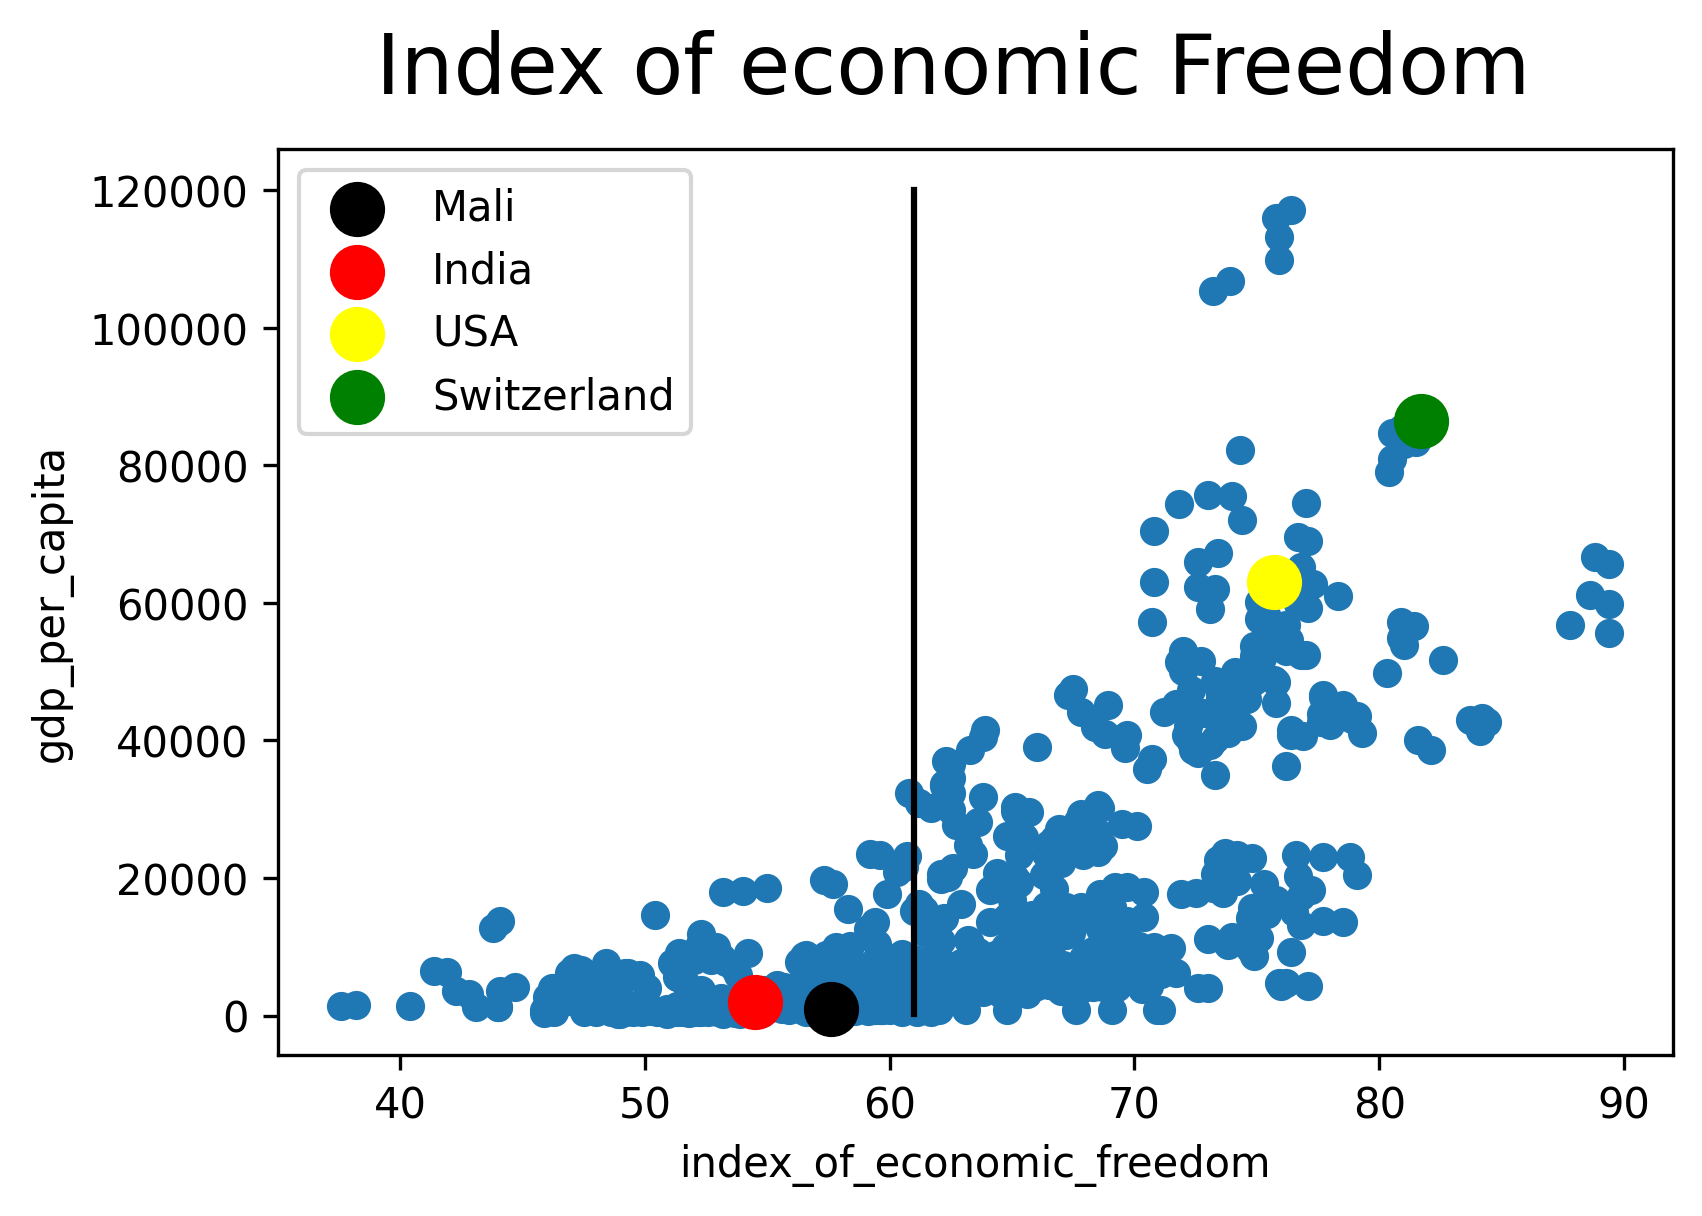

In [46]:
x = 'happiness_score'

plt.rcParams['figure.dpi']=300
plt.rcParams['savefig.dpi']=300

for i in ['import_per_person', 'export_per_person','trade_deficit','gdp_per_capita','index_of_economic_freedom']:


    fig,ax=plt.subplots()

    

    ax.scatter(final_data[x],final_data[i])

    line1,line2,line3,line4 = countries_compare(x,i)

    ax.legend([line1,line2,line3,line4],['Mali','India','USA','Switzerland'])
        
        
    # ax.plot([2.5,8],[15000,15000],c='black')
    # ax.set_ylim(0,1)
    ax.set_xlabel(x)
    ax.set_ylabel(i)
    fig.suptitle(i, fontsize=20)
    
    fig_name = "{name} and {x_value}".format(name=i,x_value=x)
    fig.savefig("figures/{name}.png".format(name=fig_name),facecolor='white', edgecolor='none')
    

x = 'index_of_economic_freedom'

for i in ['gdp_per_capita']:


    fig,ax=plt.subplots()

    plt.rcParams['figure.dpi']=300

    ax.scatter(final_data[x],final_data[i])

    line1,line2,line3,line4 = countries_compare(x,i)

    ax.legend([line1,line2,line3,line4],['Mali','India','USA','Switzerland'])
        
        
    # ax.plot([2.5,8],[15000,15000],c='black')
    # ax.set_ylim(0,1)
    ax.set_xlabel(x)
    ax.set_ylabel(i)
    ax.plot([61,61],[230,120000],c='black')
    fig.suptitle('Index of economic Freedom', fontsize=20)
    
    fig_name = "{name} and {x_value}".format(name=i,x_value=x)
    fig.savefig("figures/{name}.png".format(name=fig_name),facecolor='white', edgecolor='none')
    
    
    
    
    
    

# Observations

### The Happiness Score does correlate with Import Per Person and Export Per Person. Therefore, it is safe to say that more Global Trade leads to more happiness within a country. Suprisingly, the Trade Deficit that most politicians are fond of talking about, seems not to affect much of the happiness score of a country, proving that it's an irrational fear that has no economic nor evidentiary bases. 

### Interestingly, as many Economist suspect, the government has to do a really terrible job to make the country really unhappy. That is to say if the Index if economic freedom falls below around 62 then the unhappiness of a country depends heavily on other factors than economical ones. For that we took the example of INDIA and MALI for 2018 data. We can observe that even though Mali is little bit ahead on the economic freedom it does not affect the GDP per capita much (althogh the GDP figures are vastly different). On contrary, Switzerland and USA have somewhat similar economic freedom score yet they have vastly different GDP per capita (welfare spending doesn't count as whatever the welfare the gdp per capita will be the same).

### it can be observed that more GDP per capita leads to more Happiness Score.

## And GDP Per Capita positively correlates to the index of Economic Freedom.

### we find mild correlationship between Index of Economic Freedom and Happiness Score.



# ----------------------------------------------------------------------------------





# Now we should observe any correlation between freedom of choice and life expectancy 

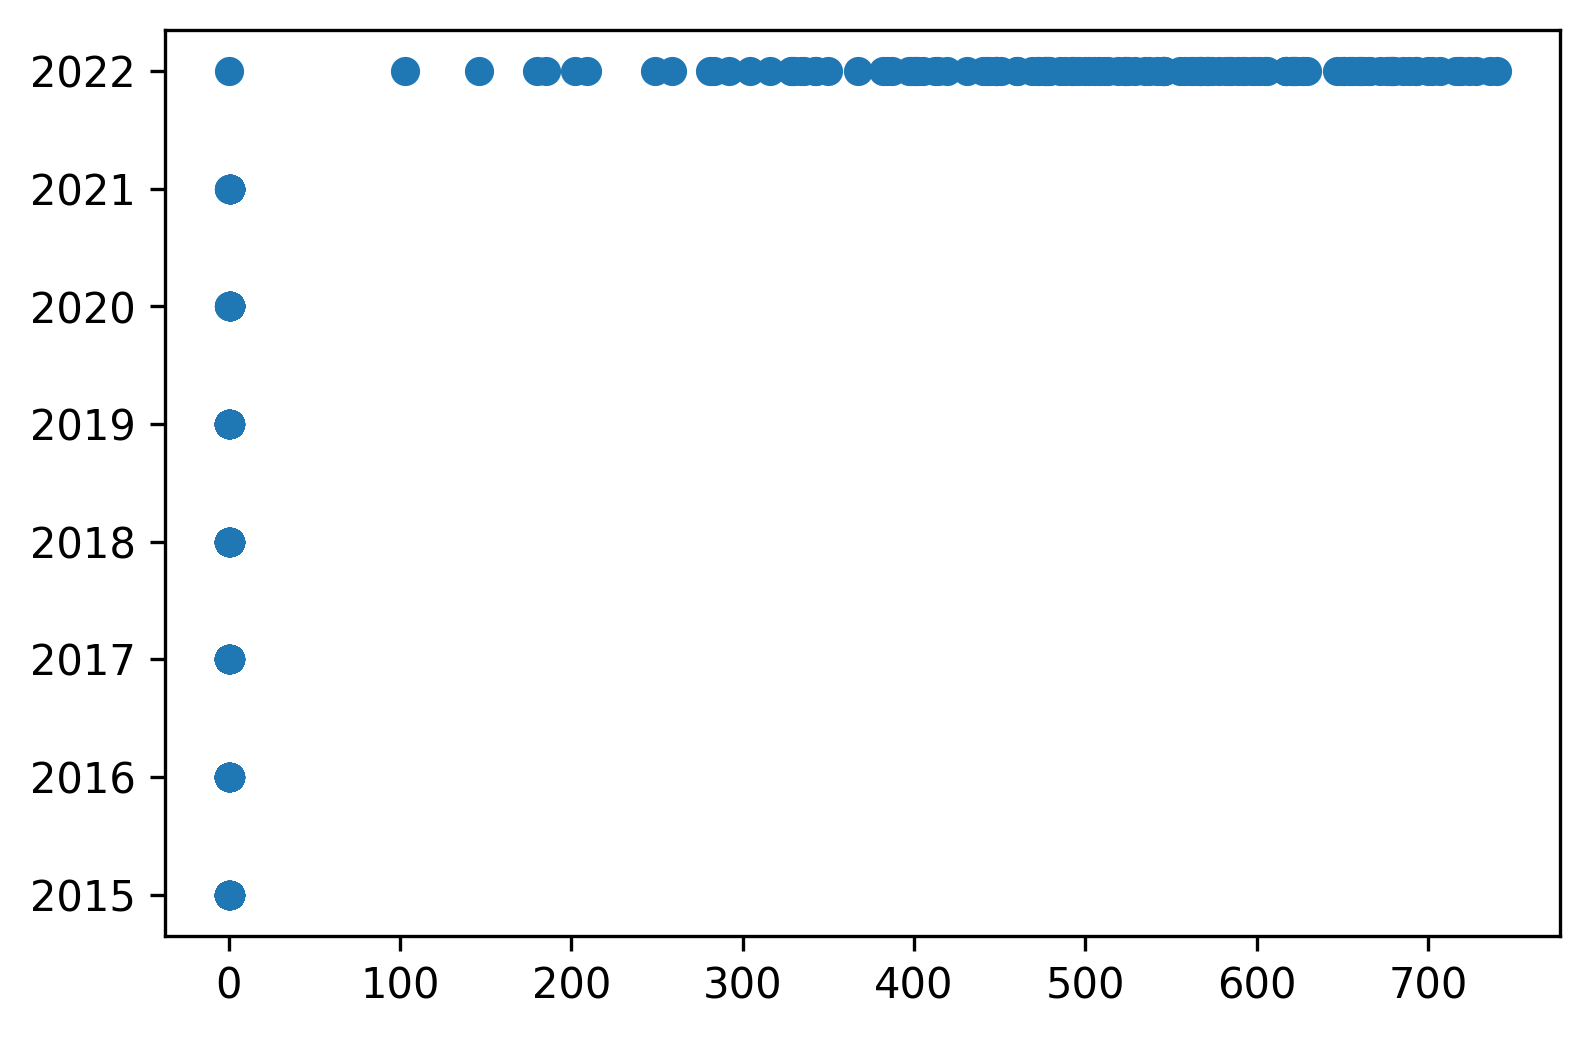

In [47]:
plt.scatter(final_data['freedom_of_choices'],final_data['year'])


they changed the measures after around 2020

In [48]:
lines='''
    SELECT * FROM final_data where year < 2020

'''

temp_data = sql.sqldf(lines)

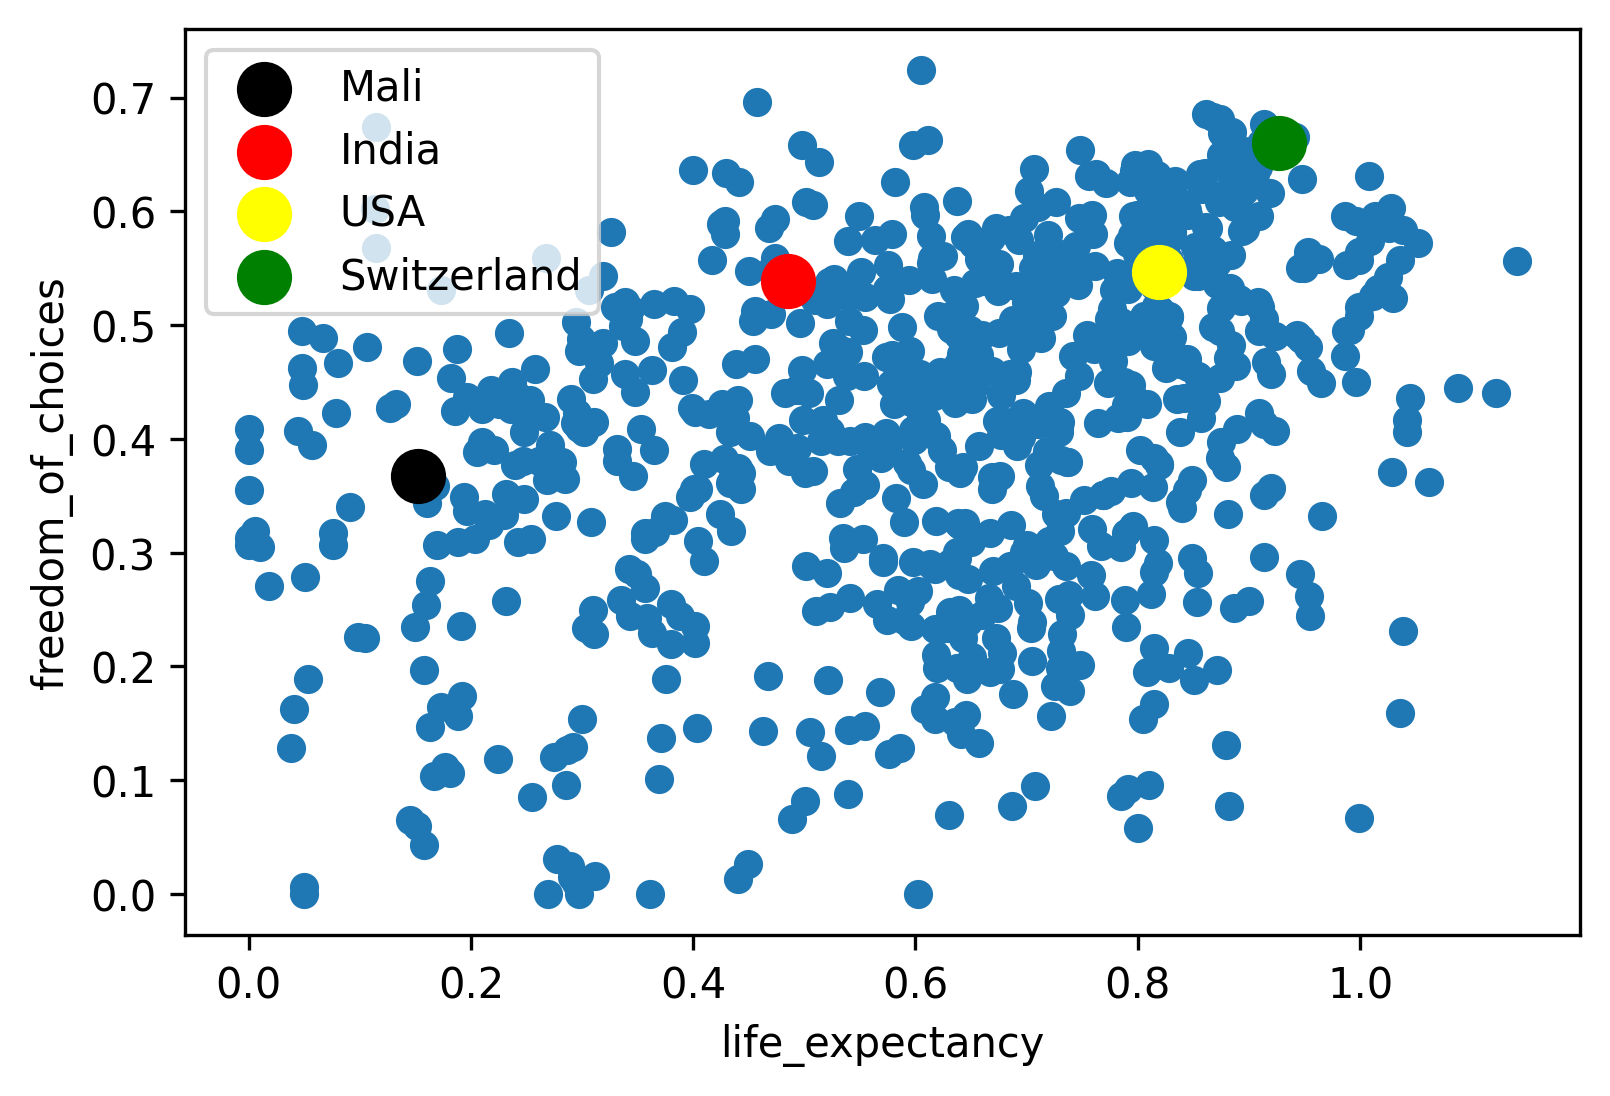

In [49]:
fig,ax=plt.subplots()

plt.rcParams['figure.dpi']=300

ax.scatter(temp_data['life_expectancy'],temp_data['freedom_of_choices'])

line1,line2,line3,line4 = countries_compare('life_expectancy','freedom_of_choices')

ax.legend([line1,line2,line3,line4],['Mali','India','USA','Switzerland'])
# ax.plot([2.5,8],[15000,15000],c='black')
# ax.set_ylim(0,1)
ax.set_xlabel('life_expectancy')
ax.set_ylabel('freedom_of_choices')
fig_name = "{name} and {x_value}".format(name='life_expectancy',x_value='freedom_of_choices')
fig.savefig("figures/{name}.png".format(name=fig_name),facecolor='white', edgecolor='none')

### from the graph it seems that there is very little linear correlationship between freedom of choice and life expectency.

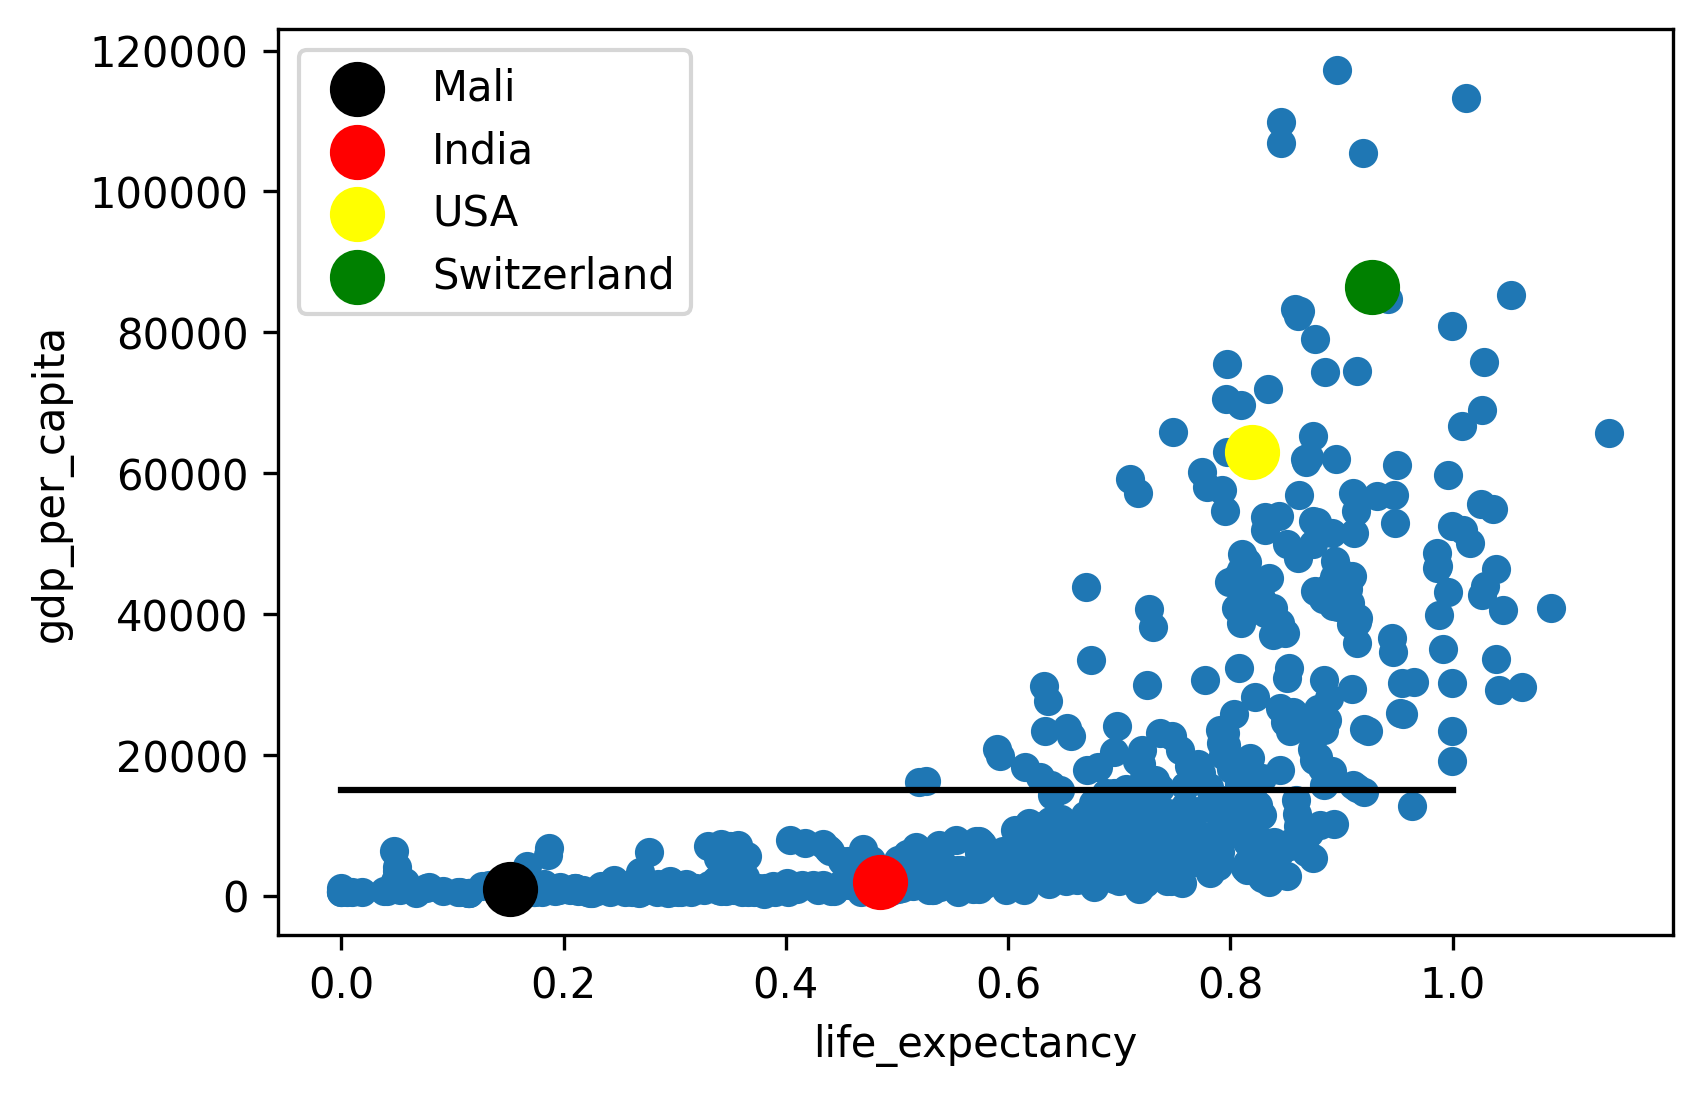

In [50]:
fig,ax=plt.subplots()

plt.rcParams['figure.dpi']=300

ax.scatter(temp_data['life_expectancy'],temp_data['gdp_per_capita'])

line1,line2,line3,line4 = countries_compare('life_expectancy','gdp_per_capita')

ax.legend([line1,line2,line3,line4],['Mali','India','USA','Switzerland'])
ax.plot([0,1],[15000,15000],c='black')
# ax.set_ylim(0,1)
ax.set_ylabel('gdp_per_capita')
ax.set_xlabel('life_expectancy')

fig_name = "{name} and {x_value}".format(name='life_expectancy',x_value='gdp_per_capita')
fig.savefig("figures/{name}.png".format(name=fig_name),facecolor='white', edgecolor='none')

## data proves that more gdp per capita leads to higher life expectancy, at least after the 15,000 USD mark.